<a href="https://colab.research.google.com/github/barrosm/DeepLearningExamples/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray Image classifier to detect pneumonia

Dataset:
> Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
> http://dx.doi.org/10.17632/rscbjbr9sj.2

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from PIL import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data augmentation

First we need to prepare our data. We have different size x-ray chest images with different brightness, body position and noise from artifacts. Although we have many samples, they might be not enough for training. Data augmentation is needed.

Our generator changes image color mode to grayscale (color is not an important feature in X-Ray images), scale to 224x224, normalize and makes some random transformations for augmentation.

In [4]:
import os
#workdir_path = '/content/drive/My Drive/BIMaster_2019/Redes_Neurais/Deep Learning/brain exercise'  # Inserir o


trainDataDir = '/content/drive/My Drive/BIMaster_2019/Redes_Neurais/input/input/chest_xray/train/'
#validationDataDir = '/content/drive/My Drive/input/chest_xray/test/'
validationDataDir = '/content/drive/My Drive/BIMaster_2019/Redes_Neurais/input/input/chest_xray/test/'


batchSize = 16
width = 224
height = 224


trainDataGen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=9,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

validationDataGen = ImageDataGenerator(
    rescale=1./255
)

trainGenerator = trainDataGen.flow_from_directory(
    trainDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    color_mode='grayscale'
)

validationGenerator = validationDataGen.flow_from_directory(
    validationDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 801 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


## Model creation

Our model is a convolutional neural network with two fully-connected layers. Architecture can be improved. However, it gives interesting results.

In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation=relu, input_shape=(width, height, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation=relu),  
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation=relu),
    Dropout(0.5),
    Dense(512, activation=relu),
    Dense(1, activation=sigmoid)
])

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

We use callbacks to track best model weights so we can do long training sessions.

Although there are more pneumonia samples than normal samples, class weight balancing is not needed, because we want to reduce the false negative cases, and the nature of the dataset is good for the case: 

In [6]:
earlyStopping = EarlyStopping(
    monitor='val_accuracy',
    mode='auto', 
    baseline=None, 
    restore_best_weights=True, 
    patience = 8,
    verbose = 1
)

stepsValidation = validationGenerator.samples // batchSize
stepsTraining = trainGenerator.samples // batchSize

history = model.fit_generator(
    generator = trainGenerator,
    steps_per_epoch = stepsTraining,
    epochs=5,
    validation_data = validationGenerator,
    validation_steps = stepsValidation,
    callbacks=[earlyStopping]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
50/50 [==============================] - 278s 6s/step - loss: 0.5790 - accuracy: 0.7325 - val_loss: 0.7142 - val_accuracy: 0.5375
Epoch 2/5
50/50 [==============================] - 11s 221ms/step - loss: 0.4104 - accuracy: 0.7783 - val_loss: 0.6748 - val_accuracy: 0.5375
Epoch 3/5
50/50 [==============================] - 11s 221ms/step - loss: 0.4636 - accuracy: 0.7643 - val_loss: 0.7315 - val_accuracy: 0.5375
Epoch 4/5
50/50 [==============================] - 11s 224ms/step - loss: 0.4462 - accuracy: 0.7478 - val_loss: 0.6483 - val_accuracy: 0.5250
Epoch 5/5
50/50 [==============================] - 11s 218ms/step - loss: 0.4201 - accuracy: 0.7567 - val_loss: 0.6202 - val_accuracy: 0.5375


## Training history and final validation: confusion matrix , ROC curve and classification report

We will use these functions to analyze the results of inferencing with our model.

In [0]:
def predictClasses(predictions):
    valResult = predictions.copy()
    valResult[valResult <= 0.5] = 0
    valResult[valResult > 0.5] = 1
    return valResult

def plotHistory(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plotConfusionMatrix(predictions, labels):
    valResult = predictClasses(predictions)
    confMatrixdf = pd.DataFrame(
        confusion_matrix(labels, valResult),
        index=["Exp. Normal", "Exp. Pneumonia"],
        columns=["Pred. Normal", "Pred. Pneumonia"]
    )

    plt.title("Confusion Matrix")
    sn.heatmap(confMatrixdf, annot=True, annot_kws={"size" : "20"})

def plotROCCurve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(fpr, tpr, 'b')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.show()

Let's look at our training history

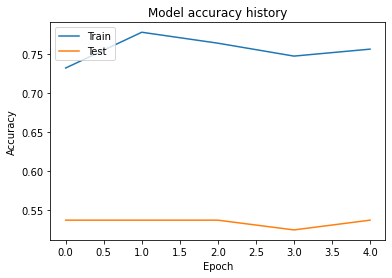

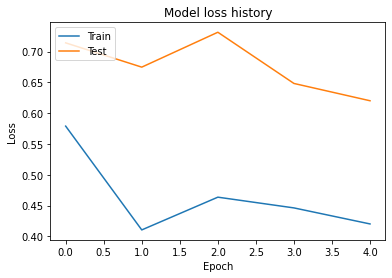

In [8]:
plotHistory(history)

Training was good. There is noticeable overfitting we need to manage to improve our accuracy.

Now it is time to analyze our model predictions through our test samples.

In [9]:
len(validationGenerator.classes)

90

Instructions for updating:
Please use Model.predict, which supports generators.


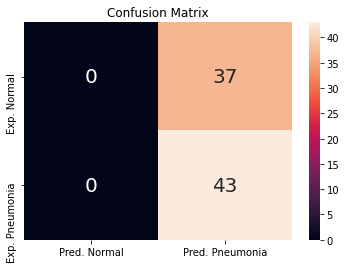

In [10]:
prediction = model.predict_generator(validationGenerator, stepsValidation)

plotConfusionMatrix(
    prediction, 
    validationGenerator.classes[:80]
)

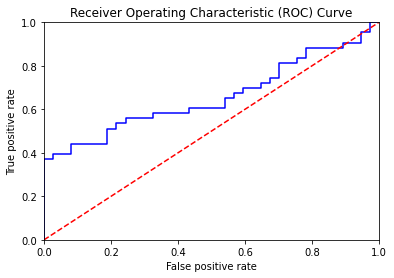


Report: 
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        37
   Pneumonia       0.54      1.00      0.70        43

    accuracy                           0.54        80
   macro avg       0.27      0.50      0.35        80
weighted avg       0.29      0.54      0.38        80



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
plotROCCurve(
    prediction,
    validationGenerator.classes[:80]
)

print(
    "\nReport: \n", 
    classification_report(
        validationGenerator.classes[:80], 
        predictClasses(prediction), 
        target_names = ["Normal", "Pneumonia"]
    )
)

As we expected, our model had better recall with pneumonia samples than with normal samples. That is a "wanted" behaviour, because we can tolerate more false positives than true positives. 

Results can always be improved. Feature engineering could be applied to search for important features which can improve accuracy. However, the nature of the images makes difficult to find a way to extract those features.

## Transfer Learning - Xception

First, we need two new generators, because Xception needs 3 channel images (RGB). As I said before, color is not a useful feature for this kind of classification. However, we want to study the power of the imagenet pretrained convolutional layers of Xception with our data.

In [13]:
xceptionTrainGenerator = trainDataGen.flow_from_directory(
    trainDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    color_mode='rgb'
)

xceptionValidationGenerator = validationDataGen.flow_from_directory(
    validationDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 801 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


Let's create our new model, using Xception convolutional layers and our own output layers.

In [17]:
xceptionConv = Xception(include_top=False, weights="imagenet", input_shape=(224,224,3))  # Aqui ele está EXCLUINDO a camada fully connected (a ultima). top ~e a ultima camada

x = Flatten()(xceptionConv.output)
x = Dropout(0.5)(x)
x = Dense(512, activation=relu)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=relu)(x)
output = Dense(1, activation=sigmoid)(x)


xceptionModel = Model(inputs=xceptionConv.input,outputs=output)

xceptionModel.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

xceptionModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [15]:
xceptionEarlyStopping = EarlyStopping(
    monitor='val_accuracy',
    mode='auto', 
    baseline=None, 
    restore_best_weights=True, 
    patience = 8,
    verbose = 1
)

xceptionHistory = xceptionModel.fit_generator(
    generator = xceptionTrainGenerator,
    steps_per_epoch = stepsTraining,
    epochs=40,
    validation_data = xceptionValidationGenerator,
    validation_steps = stepsValidation,
    callbacks=[xceptionEarlyStopping]
)

Epoch 1/40
50/50 [==============================] - 21s 417ms/step - loss: 0.6582 - accuracy: 0.7350 - val_loss: 7.7819 - val_accuracy: 0.5375
Epoch 2/40
50/50 [==============================] - 20s 399ms/step - loss: 0.2951 - accuracy: 0.8981 - val_loss: 24.4690 - val_accuracy: 0.5375
Epoch 3/40
50/50 [==============================] - 20s 401ms/step - loss: 0.5585 - accuracy: 0.8803 - val_loss: 0.3927 - val_accuracy: 0.8750
Epoch 4/40
50/50 [==============================] - 20s 393ms/step - loss: 0.7040 - accuracy: 0.8726 - val_loss: 1.3951 - val_accuracy: 0.4625
Epoch 5/40
50/50 [==============================] - 20s 393ms/step - loss: 0.8772 - accuracy: 0.7185 - val_loss: 0.8484 - val_accuracy: 0.5375
Epoch 6/40
50/50 [==============================] - 20s 394ms/step - loss: 0.6857 - accuracy: 0.7516 - val_loss: 8.5928 - val_accuracy: 0.5375
Epoch 7/40
50/50 [==============================] - 20s 394ms/step - loss: 0.4373 - accuracy: 0.7631 - val_loss: 1.1124 - val_accuracy: 0.537

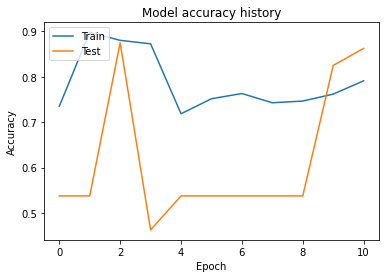

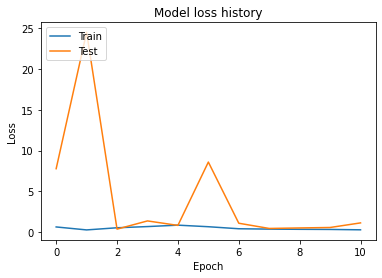

In [18]:
plotHistory(xceptionHistory)

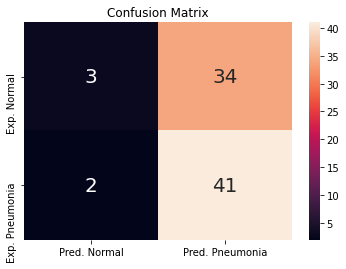

In [19]:
xceptionPrediction = xceptionModel.predict_generator(xceptionValidationGenerator, stepsValidation)

plotConfusionMatrix(
    xceptionPrediction, 
    xceptionValidationGenerator.classes[:80]
)

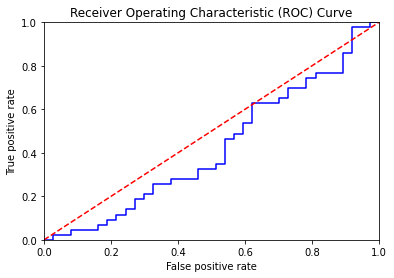


Report: 
               precision    recall  f1-score   support

      Normal       0.60      0.08      0.14        37
   Pneumonia       0.55      0.95      0.69        43

    accuracy                           0.55        80
   macro avg       0.57      0.52      0.42        80
weighted avg       0.57      0.55      0.44        80



In [20]:
plotROCCurve(
    xceptionPrediction,
    xceptionValidationGenerator.classes[:80]
)

print(
    "\nReport: \n", 
    classification_report(
        xceptionValidationGenerator.classes[:80], 
        predictClasses(xceptionPrediction), 
        target_names = ["Normal", "Pneumonia"]
    )
)

We can see than the pretained convolutional layers of the Xception Architecture with Imagenet dataset can give some interesting results, given the purpose of the Imagenet pre-trained model (1000 classes classification). However, It's overfitting much more than our custom model.

## Small testing

In [0]:
def testImage(model, file, title, width=224, height=224, color=False):
    image = Image.open(file)
    if color:
        image = image.convert("RGB")
    plt.imshow(np.asarray(image))
    data = np.array(image.resize((width,height), Image.ANTIALIAS)).reshape(1, width, height, 3 if color else 1)/255
    plt.title(title)
    plt.xlabel("Prediction: " + ("PNEUMONIA" if model.predict(data) > 0.5 else "NORMAL"))
    plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 59


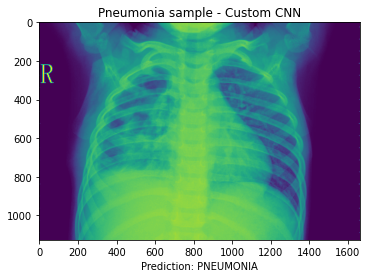

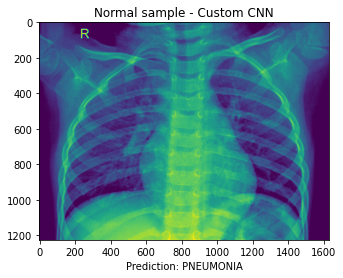

In [22]:
testImage(
    model = model,
    file ='/content/drive/My Drive/BIMaster_2019/Redes_Neurais/input/input/chest_xray/train/PNEUMONIA/person1954_bacteria_4886.jpeg',
    #'/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
    title = "Pneumonia sample - Custom CNN"
)

testImage(
    model = model,
    file = '/content/drive/My Drive/BIMaster_2019/Redes_Neurais/input/input/chest_xray/train/NORMAL/NORMAL2-IM-1440-0001.jpeg',
    #'/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg',
    title = "Normal sample - Custom CNN"
)

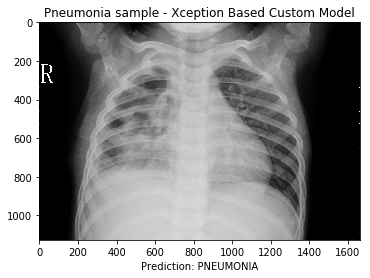

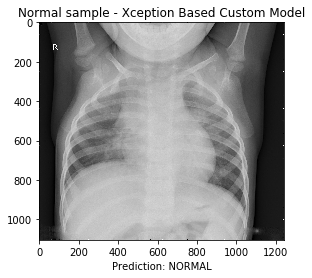

In [0]:
testImage(
    model = xceptionModel,
    file = '/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
    title = "Pneumonia sample - Xception Based Custom Model",
    color=True
)

testImage(
    model = xceptionModel,
    file = '/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg',
    title = "Normal sample - Xception Based Custom Model",
    color=True
)